# Predicting The Spurs Total Points Per Game

#### Executive Summary

- Acquired  the NBA data from Kaggle: https://www.kaggle.com/nathanlauga/nba-games

- I used seasons 2013 - 2019 

- 2013 to get averages before 2014, Train 2014-2016, Validate 2017, Test 2018 

- My top model was the LassoLars, although, none of my models were able to beat my mean baseline

#### Conclusions

- In retrospect, I think my total dataset was too small. My original thinking was to keep the years 'relevant' since I didn't think data from, let's say, 10 years ago would be applicable to more recent years

- None of my features had a strong correlation either, and with more time, I look forward to finding more features to add to my data that will help me predict the total score.

- In future iterations, I would like to incorporate an XGBoost model

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib as plt
import os

from explore import *
from prepare import *

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, explained_variance_score
from sklearn.linear_model import LinearRegression, LassoLars, TweedieRegressor
from sklearn.preprocessing import PolynomialFeatures, LabelEncoder, StandardScaler, MinMaxScaler
from scipy import stats
from sklearn.feature_selection import SelectKBest, f_regression, RFE

import warnings
warnings.filterwarnings("ignore")

### Acquire Stats for Each Game

In [2]:
games = pd.read_csv('games.csv')
games.head()

,GAME_DATE_EST,GAME_ID,GAME_STATUS_TEXT,HOME_TEAM_ID,VISITOR_TEAM_ID,SEASON,TEAM_ID_home,PTS_home,FG_PCT_home,FT_PCT_home,...,AST_home,REB_home,TEAM_ID_away,PTS_away,FG_PCT_away,FT_PCT_away,FG3_PCT_away,AST_away,REB_away,HOME_TEAM_WINS
0,2021-05-26,42000102,Final,1610612755,1610612764,2020,1610612755,120.0,0.557,0.684,...,26.0,45.0,1610612764,95.0,0.402,0.633,0.091,22.0,40.0,1
1,2021-05-26,42000132,Final,1610612752,1610612737,2020,1610612752,101.0,0.383,0.739,...,15.0,54.0,1610612737,92.0,0.369,0.818,0.273,17.0,41.0,1
2,2021-05-26,42000142,Final,1610612762,1610612763,2020,1610612762,141.0,0.544,0.774,...,28.0,42.0,1610612763,129.0,0.541,0.763,0.348,20.0,33.0,1
3,2021-05-25,42000112,Final,1610612751,1610612738,2020,1610612751,130.0,0.523,0.955,...,31.0,46.0,1610612738,108.0,0.424,0.783,0.353,23.0,43.0,1
4,2021-05-25,42000152,Final,1610612756,1610612747,2020,1610612756,102.0,0.465,0.933,...,21.0,31.0,1610612747,109.0,0.450,0.871,0.303,24.0,39.0,0


In [3]:
games.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24677 entries, 0 to 24676
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   GAME_DATE_EST     24677 non-null  object 
 1   GAME_ID           24677 non-null  int64  
 2   GAME_STATUS_TEXT  24677 non-null  object 
 3   HOME_TEAM_ID      24677 non-null  int64  
 4   VISITOR_TEAM_ID   24677 non-null  int64  
 5   SEASON            24677 non-null  int64  
 6   TEAM_ID_home      24677 non-null  int64  
 7   PTS_home          24578 non-null  float64
 8   FG_PCT_home       24578 non-null  float64
 9   FT_PCT_home       24578 non-null  float64
 10  FG3_PCT_home      24578 non-null  float64
 11  AST_home          24578 non-null  float64
 12  REB_home          24578 non-null  float64
 13  TEAM_ID_away      24677 non-null  int64  
 14  PTS_away          24578 non-null  float64
 15  FG_PCT_away       24578 non-null  float64
 16  FT_PCT_away       24578 non-null  float6

### Cleaning Data

In [4]:
# This function drops some initial unecessary columns,
# changes Game_Date_EST to datetime and sets it as the index,
# drops nulls,
# and creates a total_points column
df = clean_games_data(games)

In [5]:
df.head()

,GAME_ID,SEASON,TEAM_ID_home,PTS_home,FG_PCT_home,FT_PCT_home,FG3_PCT_home,AST_home,REB_home,TEAM_ID_away,PTS_away,FG_PCT_away,FT_PCT_away,FG3_PCT_away,AST_away,REB_away,HOME_TEAM_WINS,total_points
GAME_DATE_EST,,,,,,,,,,,,,,,,,,
2003-10-05,10300001,2003,1610612762,90.0,0.457,0.735,0.143,23.0,41.0,1610612742,85.0,0.447,0.500,0.250,20.0,38.0,1,175.0
2003-10-06,10300002,2003,1610612763,105.0,0.494,0.618,0.267,25.0,48.0,1610612749,94.0,0.427,0.700,0.154,20.0,43.0,1,199.0
2003-10-07,10300009,2003,1610612758,101.0,0.467,0.871,0.444,19.0,39.0,1610612746,82.0,0.368,0.609,0.364,13.0,50.0,1,183.0
2003-10-07,10300005,2003,1610612757,104.0,0.527,0.657,0.429,22.0,33.0,1610612745,80.0,0.470,0.667,0.333,10.0,37.0,1,184.0
2003-10-07,10300007,2003,1610612748,86.0,0.352,0.647,0.222,15.0,55.0,1610612755,79.0,0.329,0.897,0.143,7.0,44.0,1,165.0


### Creating readable team labels

In [6]:
# This function creates two new columns with 3 letter team labels
df = get_team_labels(df)

In [7]:
df.head()

,GAME_ID,SEASON,TEAM_ID_home,PTS_home,FG_PCT_home,FT_PCT_home,FG3_PCT_home,AST_home,REB_home,TEAM_ID_away,PTS_away,FG_PCT_away,FT_PCT_away,FG3_PCT_away,AST_away,REB_away,HOME_TEAM_WINS,total_points,home_team,away_team
GAME_DATE_EST,,,,,,,,,,,,,,,,,,,,
2003-10-05,10300001,2003,1610612762,90.0,0.457,0.735,0.143,23.0,41.0,1610612742,85.0,0.447,0.500,0.250,20.0,38.0,1,175.0,UTA,DAL
2003-10-06,10300002,2003,1610612763,105.0,0.494,0.618,0.267,25.0,48.0,1610612749,94.0,0.427,0.700,0.154,20.0,43.0,1,199.0,MEM,MIL
2003-10-07,10300009,2003,1610612758,101.0,0.467,0.871,0.444,19.0,39.0,1610612746,82.0,0.368,0.609,0.364,13.0,50.0,1,183.0,SAC,LAC
2003-10-07,10300005,2003,1610612757,104.0,0.527,0.657,0.429,22.0,33.0,1610612745,80.0,0.470,0.667,0.333,10.0,37.0,1,184.0,POR,HOU
2003-10-07,10300007,2003,1610612748,86.0,0.352,0.647,0.222,15.0,55.0,1610612755,79.0,0.329,0.897,0.143,7.0,44.0,1,165.0,MIA,PHI


## Engineer Average Features
I won't be able to use these actual stats for my model, but I can create rolling averages 

#### Create the DF that I will use for Train, Validate, Test

- I will use the 2018-2019 for my test since it was the last full season. 2019-2020 was suspended due to covid, and 2020-2021 was shortened. 

- I'll validate on 2017-2018 and train on 3 seasons prior

- I'll add one extra season (2013-2014) so I can get the averages going before my train starts

- In total: 2013-2019 (Seasons 2013, 2014, 2015, 2016, 2017, 2018)

In [8]:
# Creating a dataframe with just the seasons I want
df = df[(df.SEASON == 2013)|(df.SEASON == 2014)|(df.SEASON == 2015)|\
        (df.SEASON == 2016)|(df.SEASON == 2017)|(df.SEASON == 2018)]

In [9]:
# Creating a dataframe where the Spurs are either home or away team
spurs = df[(df.home_team == 'SAS')|(df.away_team == 'SAS')]

#### Created a spurs score for each game

In [10]:
# This column is our target variable, it shows how many points the Spurs scored whether home or away
spurs['spurs_score'] = spurs.apply(lambda x: x.PTS_home if x.home_team == 'SAS' else x.PTS_away, axis=1)

In [11]:
spurs

,GAME_ID,SEASON,TEAM_ID_home,PTS_home,FG_PCT_home,FT_PCT_home,FG3_PCT_home,AST_home,REB_home,TEAM_ID_away,...,FG_PCT_away,FT_PCT_away,FG3_PCT_away,AST_away,REB_away,HOME_TEAM_WINS,total_points,home_team,away_team,spurs_score
GAME_DATE_EST,,,,,,,,,,,,,,,,,,,,,
2013-10-13,11300045,2013,1610612759,99.0,0.451,0.826,0.333,27.0,39.0,1610612756,...,0.461,0.667,0.370,22.0,45.0,0,205.0,SAS,PHX,99.0
2013-10-14,11300048,2013,1610612743,98.0,0.409,0.630,0.208,22.0,51.0,1610612759,...,0.466,0.588,0.500,24.0,50.0,1,192.0,DEN,SAS,94.0
2013-10-17,11300068,2013,1610612737,104.0,0.453,0.655,0.333,30.0,42.0,1610612759,...,0.477,0.813,0.346,23.0,47.0,0,210.0,ATL,SAS,106.0
2013-10-19,11300076,2013,1610612748,121.0,0.568,0.727,0.464,25.0,39.0,1610612759,...,0.411,0.926,0.458,24.0,40.0,1,217.0,MIA,SAS,96.0
2013-10-22,11300091,2013,1610612759,123.0,0.534,0.818,0.423,28.0,45.0,1610612753,...,0.447,0.889,0.529,22.0,42.0,1,224.0,SAS,ORL,123.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-04-18,41800153,2018,1610612759,118.0,0.494,0.719,0.389,24.0,45.0,1610612743,...,0.519,0.529,0.517,31.0,37.0,1,226.0,SAS,DEN,118.0
2019-04-20,41800154,2018,1610612759,103.0,0.468,0.750,0.294,23.0,46.0,1610612743,...,0.449,0.917,0.484,25.0,45.0,0,220.0,SAS,DEN,103.0
2019-04-23,41800155,2018,1610612743,108.0,0.500,0.800,0.424,25.0,49.0,1610612759,...,0.411,0.600,0.292,17.0,42.0,1,198.0,DEN,SAS,90.0


#### Create a rolling Average Points of the past 5 games

In [12]:
# Create home DF
spurs_home = spurs[spurs.home_team=='SAS']
# Create a rolling average of the past 5 games at home
spurs_home['5_game_avg_pts_home'] = spurs_home['PTS_home'].rolling(5).mean()
# Create away DF
spurs_away = spurs[spurs.away_team == 'SAS']
# Create a rolling average of the past 5 games away
spurs_away['5_game_avg_pts_away'] = spurs_away['PTS_away'].rolling(5).mean()
# Concat the two df's together
spurs_avg_pts = [spurs_home,spurs_away]
spurs = pd.concat(spurs_avg_pts)
# Sort the index
spurs.sort_index(inplace=True)
# Forward fill NaN's with the averages 
spurs.fillna(method='ffill',inplace=True)
# Fill rest of the Nan's with zeros
spurs.fillna(0, inplace=True)
spurs.head(15)

,GAME_ID,SEASON,TEAM_ID_home,PTS_home,FG_PCT_home,FT_PCT_home,FG3_PCT_home,AST_home,REB_home,TEAM_ID_away,...,FG3_PCT_away,AST_away,REB_away,HOME_TEAM_WINS,total_points,home_team,away_team,spurs_score,5_game_avg_pts_home,5_game_avg_pts_away
GAME_DATE_EST,,,,,,,,,,,,,,,,,,,,,
2013-10-13,11300045,2013,1610612759,99.0,0.451,0.826,0.333,27.0,39.0,1610612756,...,0.370,22.0,45.0,0,205.0,SAS,PHX,99.0,0.0,0.0
2013-10-14,11300048,2013,1610612743,98.0,0.409,0.630,0.208,22.0,51.0,1610612759,...,0.500,24.0,50.0,1,192.0,DEN,SAS,94.0,0.0,0.0
2013-10-17,11300068,2013,1610612737,104.0,0.453,0.655,0.333,30.0,42.0,1610612759,...,0.346,23.0,47.0,0,210.0,ATL,SAS,106.0,0.0,0.0
2013-10-19,11300076,2013,1610612748,121.0,0.568,0.727,0.464,25.0,39.0,1610612759,...,0.458,24.0,40.0,1,217.0,MIA,SAS,96.0,0.0,0.0
2013-10-22,11300091,2013,1610612759,123.0,0.534,0.818,0.423,28.0,45.0,1610612753,...,0.529,22.0,42.0,1,224.0,SAS,ORL,123.0,0.0,0.0
2013-10-24,11300105,2013,1610612759,92.0,0.398,0.882,0.389,26.0,41.0,1610612745,...,0.342,27.0,51.0,0,201.0,SAS,HOU,92.0,0.0,0.0
2013-10-30,21300013,2013,1610612759,101.0,0.526,0.625,0.550,25.0,40.0,1610612763,...,0.533,24.0,44.0,1,195.0,SAS,MEM,101.0,0.0,0.0
2013-11-01,21300032,2013,1610612747,85.0,0.366,0.708,0.296,22.0,46.0,1610612759,...,0.238,20.0,50.0,0,176.0,LAL,SAS,91.0,0.0,0.0
2013-11-02,21300039,2013,1610612757,115.0,0.556,0.895,0.400,29.0,39.0,1610612759,...,0.500,24.0,35.0,1,220.0,POR,SAS,105.0,0.0,98.4


#### Create rolling Average Field Goal Percentage

In [13]:
# Create home DF
spurs_home = spurs[spurs.home_team=='SAS']
# Create a rolling average of the past 5 games at home
spurs_home['5_game_avg_fg_pct_home'] = spurs_home['FG_PCT_home'].rolling(5).mean()
# Create away DF
spurs_away = spurs[spurs.away_team == 'SAS']
# Create a rolling average of the past 5 games away
spurs_away['5_game_avg_fg_pct_away'] = spurs_away['FG_PCT_away'].rolling(5).mean()
# Concat the two df's together
spurs_avg_pts = [spurs_home,spurs_away]
spurs = pd.concat(spurs_avg_pts)
# Sort the index
spurs.sort_index(inplace=True)
# Forward fill NaN's with the averages 
spurs.fillna(method='ffill',inplace=True)
# Fill rest of the Nan's with zeros
spurs.fillna(0, inplace=True)
spurs.head(15)

,GAME_ID,SEASON,TEAM_ID_home,PTS_home,FG_PCT_home,FT_PCT_home,FG3_PCT_home,AST_home,REB_home,TEAM_ID_away,...,REB_away,HOME_TEAM_WINS,total_points,home_team,away_team,spurs_score,5_game_avg_pts_home,5_game_avg_pts_away,5_game_avg_fg_pct_home,5_game_avg_fg_pct_away
GAME_DATE_EST,,,,,,,,,,,,,,,,,,,,,
2013-10-13,11300045,2013,1610612759,99.0,0.451,0.826,0.333,27.0,39.0,1610612756,...,45.0,0,205.0,SAS,PHX,99.0,0.0,0.0,0.0000,0.0000
2013-10-14,11300048,2013,1610612743,98.0,0.409,0.630,0.208,22.0,51.0,1610612759,...,50.0,1,192.0,DEN,SAS,94.0,0.0,0.0,0.0000,0.0000
2013-10-17,11300068,2013,1610612737,104.0,0.453,0.655,0.333,30.0,42.0,1610612759,...,47.0,0,210.0,ATL,SAS,106.0,0.0,0.0,0.0000,0.0000
2013-10-19,11300076,2013,1610612748,121.0,0.568,0.727,0.464,25.0,39.0,1610612759,...,40.0,1,217.0,MIA,SAS,96.0,0.0,0.0,0.0000,0.0000
2013-10-22,11300091,2013,1610612759,123.0,0.534,0.818,0.423,28.0,45.0,1610612753,...,42.0,1,224.0,SAS,ORL,123.0,0.0,0.0,0.0000,0.0000
2013-10-24,11300105,2013,1610612759,92.0,0.398,0.882,0.389,26.0,41.0,1610612745,...,51.0,0,201.0,SAS,HOU,92.0,0.0,0.0,0.0000,0.0000
2013-10-30,21300013,2013,1610612759,101.0,0.526,0.625,0.550,25.0,40.0,1610612763,...,44.0,1,195.0,SAS,MEM,101.0,0.0,0.0,0.0000,0.0000
2013-11-01,21300032,2013,1610612747,85.0,0.366,0.708,0.296,22.0,46.0,1610612759,...,50.0,0,176.0,LAL,SAS,91.0,0.0,0.0,0.0000,0.0000
2013-11-02,21300039,2013,1610612757,115.0,0.556,0.895,0.400,29.0,39.0,1610612759,...,35.0,1,220.0,POR,SAS,105.0,0.0,98.4,0.0000,0.4516


#### Create rolling Average Free Throw Percentage

In [14]:
# Create home DF
spurs_home = spurs[spurs.home_team=='SAS']
# Create a rolling average of the past 5 games at home
spurs_home['5_game_avg_ft_pct_home'] = spurs_home['FT_PCT_home'].rolling(5).mean()
# Create away DF
spurs_away = spurs[spurs.away_team == 'SAS']
# Create a rolling average of the past 5 games away
spurs_away['5_game_avg_ft_pct_away'] = spurs_away['FT_PCT_away'].rolling(5).mean()
# Concat the two df's together
spurs_avg_pts = [spurs_home,spurs_away]
spurs = pd.concat(spurs_avg_pts)
# Sort the index
spurs.sort_index(inplace=True)
# Forward fill NaN's with the averages 
spurs.fillna(method='ffill',inplace=True)
# Fill rest of the Nan's with zeros
spurs.fillna(0, inplace=True)
spurs.head(15)

,GAME_ID,SEASON,TEAM_ID_home,PTS_home,FG_PCT_home,FT_PCT_home,FG3_PCT_home,AST_home,REB_home,TEAM_ID_away,...,total_points,home_team,away_team,spurs_score,5_game_avg_pts_home,5_game_avg_pts_away,5_game_avg_fg_pct_home,5_game_avg_fg_pct_away,5_game_avg_ft_pct_home,5_game_avg_ft_pct_away
GAME_DATE_EST,,,,,,,,,,,,,,,,,,,,,
2013-10-13,11300045,2013,1610612759,99.0,0.451,0.826,0.333,27.0,39.0,1610612756,...,205.0,SAS,PHX,99.0,0.0,0.0,0.0000,0.0000,0.0000,0.0000
2013-10-14,11300048,2013,1610612743,98.0,0.409,0.630,0.208,22.0,51.0,1610612759,...,192.0,DEN,SAS,94.0,0.0,0.0,0.0000,0.0000,0.0000,0.0000
2013-10-17,11300068,2013,1610612737,104.0,0.453,0.655,0.333,30.0,42.0,1610612759,...,210.0,ATL,SAS,106.0,0.0,0.0,0.0000,0.0000,0.0000,0.0000
2013-10-19,11300076,2013,1610612748,121.0,0.568,0.727,0.464,25.0,39.0,1610612759,...,217.0,MIA,SAS,96.0,0.0,0.0,0.0000,0.0000,0.0000,0.0000
2013-10-22,11300091,2013,1610612759,123.0,0.534,0.818,0.423,28.0,45.0,1610612753,...,224.0,SAS,ORL,123.0,0.0,0.0,0.0000,0.0000,0.0000,0.0000
2013-10-24,11300105,2013,1610612759,92.0,0.398,0.882,0.389,26.0,41.0,1610612745,...,201.0,SAS,HOU,92.0,0.0,0.0,0.0000,0.0000,0.0000,0.0000
2013-10-30,21300013,2013,1610612759,101.0,0.526,0.625,0.550,25.0,40.0,1610612763,...,195.0,SAS,MEM,101.0,0.0,0.0,0.0000,0.0000,0.0000,0.0000
2013-11-01,21300032,2013,1610612747,85.0,0.366,0.708,0.296,22.0,46.0,1610612759,...,176.0,LAL,SAS,91.0,0.0,0.0,0.0000,0.0000,0.0000,0.0000
2013-11-02,21300039,2013,1610612757,115.0,0.556,0.895,0.400,29.0,39.0,1610612759,...,220.0,POR,SAS,105.0,0.0,98.4,0.0000,0.4516,0.0000,0.7332


#### Create rolling Average 3 Point Field Goal Percentage

In [15]:
# Create home DF
spurs_home = spurs[spurs.home_team=='SAS']
# Create a rolling average of the past 5 games at home
spurs_home['5_game_avg_fg3_pct_home'] = spurs_home['FG3_PCT_home'].rolling(5).mean()
# Create away DF
spurs_away = spurs[spurs.away_team == 'SAS']
# Create a rolling average of the past 5 games away
spurs_away['5_game_avg_fg3_pct_away'] = spurs_away['FG3_PCT_away'].rolling(5).mean()
# Concat the two df's together
spurs_avg_pts = [spurs_home,spurs_away]
spurs = pd.concat(spurs_avg_pts)
# Sort the index
spurs.sort_index(inplace=True)
# Forward fill NaN's with the averages 
spurs.fillna(method='ffill',inplace=True)
# Fill rest of the Nan's with zeros
spurs.fillna(0, inplace=True)
spurs.head(15)

,GAME_ID,SEASON,TEAM_ID_home,PTS_home,FG_PCT_home,FT_PCT_home,FG3_PCT_home,AST_home,REB_home,TEAM_ID_away,...,away_team,spurs_score,5_game_avg_pts_home,5_game_avg_pts_away,5_game_avg_fg_pct_home,5_game_avg_fg_pct_away,5_game_avg_ft_pct_home,5_game_avg_ft_pct_away,5_game_avg_fg3_pct_home,5_game_avg_fg3_pct_away
GAME_DATE_EST,,,,,,,,,,,,,,,,,,,,,
2013-10-13,11300045,2013,1610612759,99.0,0.451,0.826,0.333,27.0,39.0,1610612756,...,PHX,99.0,0.0,0.0,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
2013-10-14,11300048,2013,1610612743,98.0,0.409,0.630,0.208,22.0,51.0,1610612759,...,SAS,94.0,0.0,0.0,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
2013-10-17,11300068,2013,1610612737,104.0,0.453,0.655,0.333,30.0,42.0,1610612759,...,SAS,106.0,0.0,0.0,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
2013-10-19,11300076,2013,1610612748,121.0,0.568,0.727,0.464,25.0,39.0,1610612759,...,SAS,96.0,0.0,0.0,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
2013-10-22,11300091,2013,1610612759,123.0,0.534,0.818,0.423,28.0,45.0,1610612753,...,ORL,123.0,0.0,0.0,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
2013-10-24,11300105,2013,1610612759,92.0,0.398,0.882,0.389,26.0,41.0,1610612745,...,HOU,92.0,0.0,0.0,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
2013-10-30,21300013,2013,1610612759,101.0,0.526,0.625,0.550,25.0,40.0,1610612763,...,MEM,101.0,0.0,0.0,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
2013-11-01,21300032,2013,1610612747,85.0,0.366,0.708,0.296,22.0,46.0,1610612759,...,SAS,91.0,0.0,0.0,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
2013-11-02,21300039,2013,1610612757,115.0,0.556,0.895,0.400,29.0,39.0,1610612759,...,SAS,105.0,0.0,98.4,0.0000,0.4516,0.0000,0.7332,0.0000,0.4084


#### Create rolling Average Assists

In [16]:
# Create home DF
spurs_home = spurs[spurs.home_team=='SAS']
# Create a rolling average of the past 5 games at home
spurs_home['5_game_avg_assists_home'] = spurs_home['AST_home'].rolling(5).mean()
# Create away DF
spurs_away = spurs[spurs.away_team == 'SAS']
# Create a rolling average of the past 5 games away
spurs_away['5_game_avg_assists_away'] = spurs_away['AST_away'].rolling(5).mean()
# Concat the two df's together
spurs_avg_pts = [spurs_home,spurs_away]
spurs = pd.concat(spurs_avg_pts)
# Sort the index
spurs.sort_index(inplace=True)
# Forward fill NaN's with the averages 
spurs.fillna(method='ffill',inplace=True)
# Fill rest of the Nan's with zeros
spurs.fillna(0, inplace=True)
spurs.head(15)

,GAME_ID,SEASON,TEAM_ID_home,PTS_home,FG_PCT_home,FT_PCT_home,FG3_PCT_home,AST_home,REB_home,TEAM_ID_away,...,5_game_avg_pts_home,5_game_avg_pts_away,5_game_avg_fg_pct_home,5_game_avg_fg_pct_away,5_game_avg_ft_pct_home,5_game_avg_ft_pct_away,5_game_avg_fg3_pct_home,5_game_avg_fg3_pct_away,5_game_avg_assists_home,5_game_avg_assists_away
GAME_DATE_EST,,,,,,,,,,,,,,,,,,,,,
2013-10-13,11300045,2013,1610612759,99.0,0.451,0.826,0.333,27.0,39.0,1610612756,...,0.0,0.0,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0,0.0
2013-10-14,11300048,2013,1610612743,98.0,0.409,0.630,0.208,22.0,51.0,1610612759,...,0.0,0.0,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0,0.0
2013-10-17,11300068,2013,1610612737,104.0,0.453,0.655,0.333,30.0,42.0,1610612759,...,0.0,0.0,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0,0.0
2013-10-19,11300076,2013,1610612748,121.0,0.568,0.727,0.464,25.0,39.0,1610612759,...,0.0,0.0,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0,0.0
2013-10-22,11300091,2013,1610612759,123.0,0.534,0.818,0.423,28.0,45.0,1610612753,...,0.0,0.0,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0,0.0
2013-10-24,11300105,2013,1610612759,92.0,0.398,0.882,0.389,26.0,41.0,1610612745,...,0.0,0.0,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0,0.0
2013-10-30,21300013,2013,1610612759,101.0,0.526,0.625,0.550,25.0,40.0,1610612763,...,0.0,0.0,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0,0.0
2013-11-01,21300032,2013,1610612747,85.0,0.366,0.708,0.296,22.0,46.0,1610612759,...,0.0,0.0,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0,0.0
2013-11-02,21300039,2013,1610612757,115.0,0.556,0.895,0.400,29.0,39.0,1610612759,...,0.0,98.4,0.0000,0.4516,0.0000,0.7332,0.0000,0.4084,0.0,23.0


#### Create rolling Average Rebounds

In [17]:
# Create home DF
spurs_home = spurs[spurs.home_team=='SAS']
# Create a rolling average of the past 5 games at home
spurs_home['5_game_avg_rebounds_home'] = spurs_home['REB_home'].rolling(5).mean()
# Create away DF
spurs_away = spurs[spurs.away_team == 'SAS']
# Create a rolling average of the past 5 games away
spurs_away['5_game_avg_rebounds_away'] = spurs_away['REB_away'].rolling(5).mean()
# Concat the two df's together
spurs_avg_pts = [spurs_home,spurs_away]
spurs = pd.concat(spurs_avg_pts)
# Sort the index
spurs.sort_index(inplace=True)
# Forward fill NaN's with the averages 
spurs.fillna(method='ffill',inplace=True)
# Fill rest of the Nan's with zeros
spurs.fillna(0, inplace=True)
spurs.head(15)

,GAME_ID,SEASON,TEAM_ID_home,PTS_home,FG_PCT_home,FT_PCT_home,FG3_PCT_home,AST_home,REB_home,TEAM_ID_away,...,5_game_avg_fg_pct_home,5_game_avg_fg_pct_away,5_game_avg_ft_pct_home,5_game_avg_ft_pct_away,5_game_avg_fg3_pct_home,5_game_avg_fg3_pct_away,5_game_avg_assists_home,5_game_avg_assists_away,5_game_avg_rebounds_home,5_game_avg_rebounds_away
GAME_DATE_EST,,,,,,,,,,,,,,,,,,,,,
2013-10-13,11300045,2013,1610612759,99.0,0.451,0.826,0.333,27.0,39.0,1610612756,...,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0,0.0,0.0,0.0
2013-10-14,11300048,2013,1610612743,98.0,0.409,0.630,0.208,22.0,51.0,1610612759,...,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0,0.0,0.0,0.0
2013-10-17,11300068,2013,1610612737,104.0,0.453,0.655,0.333,30.0,42.0,1610612759,...,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0,0.0,0.0,0.0
2013-10-19,11300076,2013,1610612748,121.0,0.568,0.727,0.464,25.0,39.0,1610612759,...,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0,0.0,0.0,0.0
2013-10-22,11300091,2013,1610612759,123.0,0.534,0.818,0.423,28.0,45.0,1610612753,...,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0,0.0,0.0,0.0
2013-10-24,11300105,2013,1610612759,92.0,0.398,0.882,0.389,26.0,41.0,1610612745,...,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0,0.0,0.0,0.0
2013-10-30,21300013,2013,1610612759,101.0,0.526,0.625,0.550,25.0,40.0,1610612763,...,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0,0.0,0.0,0.0
2013-11-01,21300032,2013,1610612747,85.0,0.366,0.708,0.296,22.0,46.0,1610612759,...,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0,0.0,0.0,0.0
2013-11-02,21300039,2013,1610612757,115.0,0.556,0.895,0.400,29.0,39.0,1610612759,...,0.0000,0.4516,0.0000,0.7332,0.0000,0.4084,0.0,23.0,0.0,44.4


#### Now lets take off the 2013 Season

In [18]:
# I used the 2013 season to get the averages to start the 2014 season, now removing the 2013 season
spurs = spurs[spurs.SEASON != 2013]
spurs

,GAME_ID,SEASON,TEAM_ID_home,PTS_home,FG_PCT_home,FT_PCT_home,FG3_PCT_home,AST_home,REB_home,TEAM_ID_away,...,5_game_avg_fg_pct_home,5_game_avg_fg_pct_away,5_game_avg_ft_pct_home,5_game_avg_ft_pct_away,5_game_avg_fg3_pct_home,5_game_avg_fg3_pct_away,5_game_avg_assists_home,5_game_avg_assists_away,5_game_avg_rebounds_home,5_game_avg_rebounds_away
GAME_DATE_EST,,,,,,,,,,,,,,,,,,,,,
2014-10-16,11400062,2014,1610612756,121.0,0.556,0.625,0.524,27.0,36.0,1610612759,...,0.5028,0.4822,0.7872,0.7436,0.4670,0.3578,26.2,20.6,43.4,40.8
2014-10-18,11400078,2014,1610612759,108.0,0.413,0.833,0.387,27.0,50.0,1610612748,...,0.4854,0.4822,0.7712,0.7436,0.4662,0.3578,26.2,20.6,42.8,40.8
2014-10-20,11400091,2014,1610612759,106.0,0.468,0.889,0.308,24.0,36.0,1610612758,...,0.4764,0.4822,0.7756,0.7436,0.4278,0.3578,26.4,20.6,40.4,40.8
2014-10-22,11400105,2014,1610612759,107.0,0.532,0.818,0.318,25.0,38.0,1610612737,...,0.4652,0.4822,0.7846,0.7436,0.3874,0.3578,25.4,20.6,40.2,40.8
2014-10-24,11400113,2014,1610612745,96.0,0.422,0.647,0.429,16.0,46.0,1610612759,...,0.4652,0.4838,0.7846,0.7476,0.3874,0.3528,25.4,22.0,40.2,40.2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-04-18,41800153,2018,1610612759,118.0,0.494,0.719,0.389,24.0,45.0,1610612743,...,0.4964,0.4804,0.7672,0.7846,0.3818,0.3478,24.0,23.2,43.6,45.2
2019-04-20,41800154,2018,1610612759,103.0,0.468,0.750,0.294,23.0,46.0,1610612743,...,0.4842,0.4804,0.7760,0.7846,0.3558,0.3478,23.2,23.2,46.2,45.2
2019-04-23,41800155,2018,1610612743,108.0,0.500,0.800,0.424,25.0,49.0,1610612759,...,0.4842,0.4860,0.7760,0.7606,0.3558,0.3692,23.2,23.6,46.2,46.0


Now our data frame starts with the averages from the previous season rather than null or 0

## Explore

In [19]:
# You know me, read that DF into a csv for some Tableau!
spurs.to_csv('spurs_2014_2019.csv')

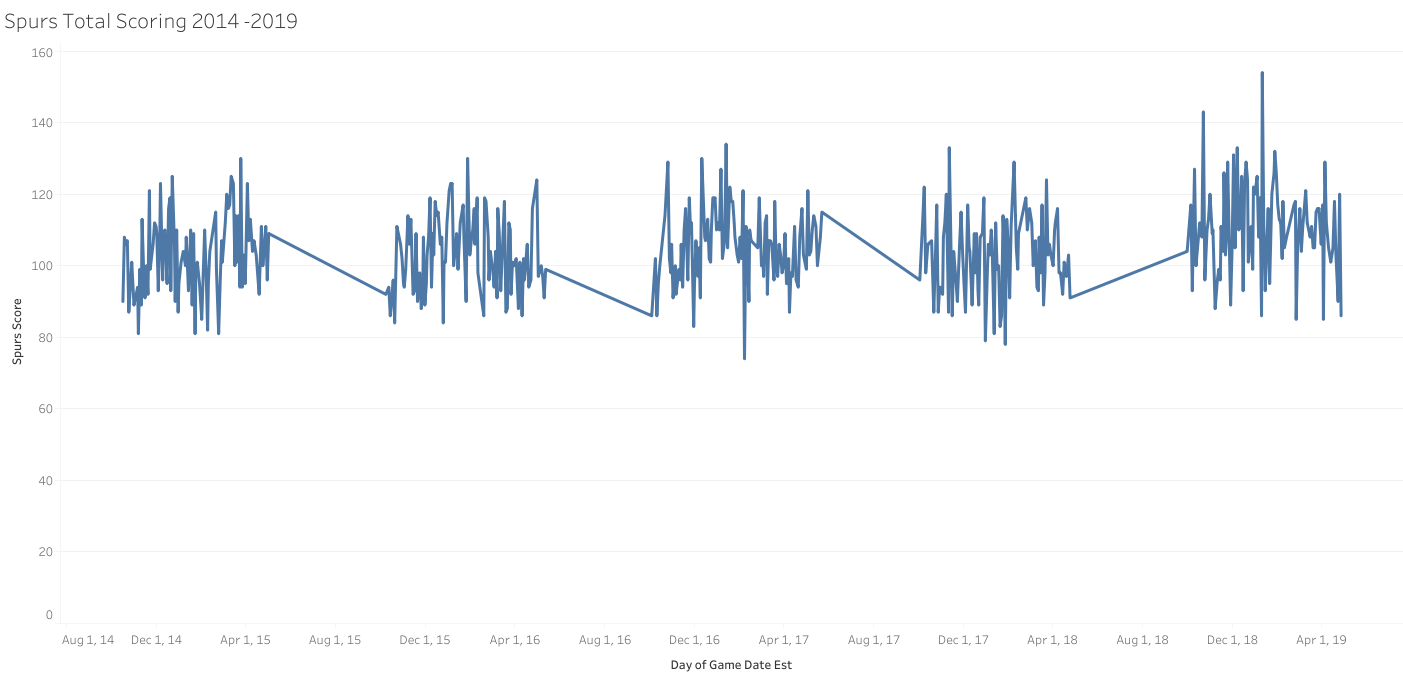

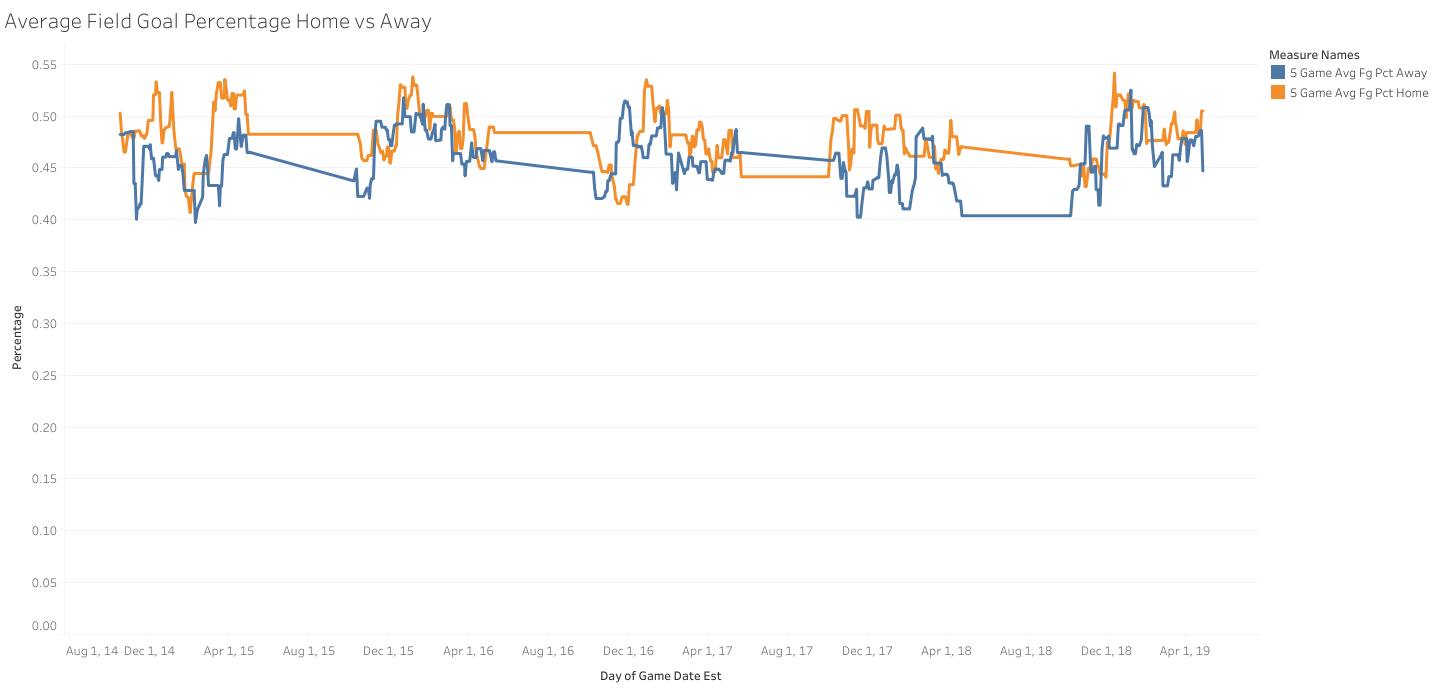

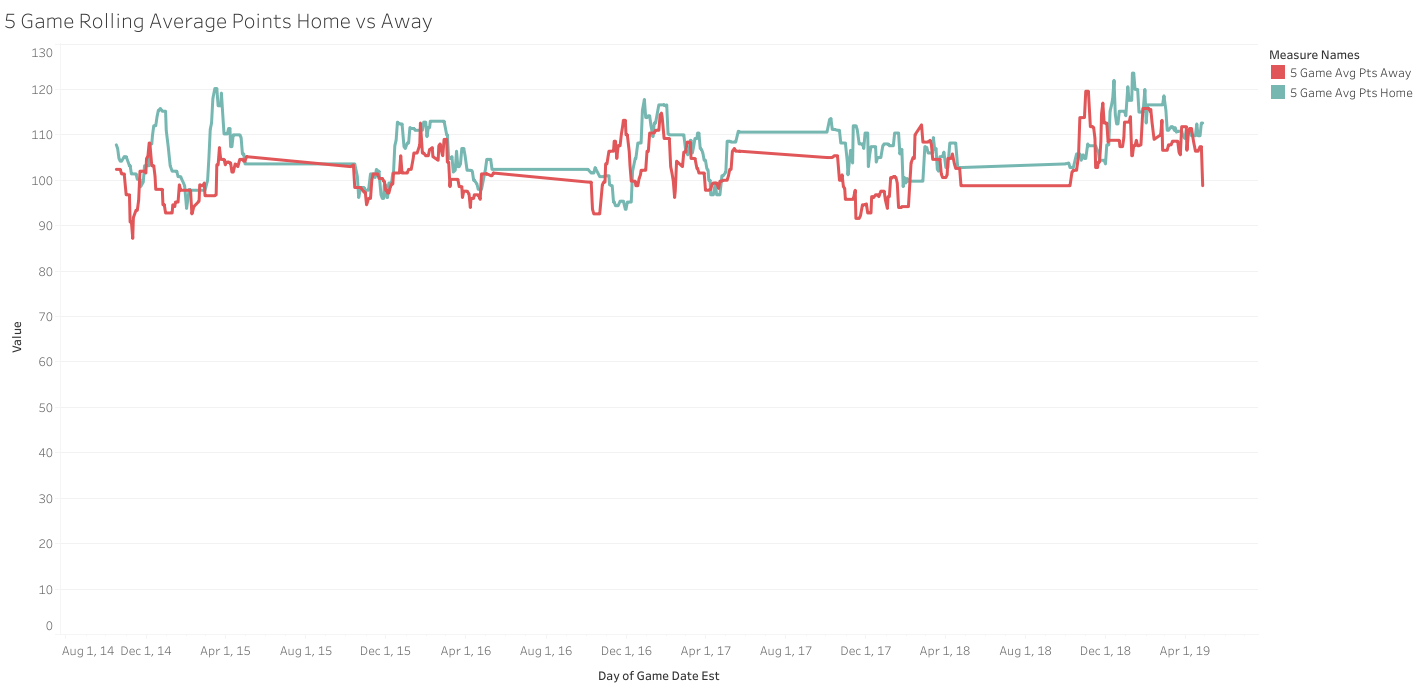

#### Takeaways:
- It appears the Spurs score better overall at home than away!

### Drop Columns

In [20]:
spurs.columns

Index(['GAME_ID', 'SEASON', 'TEAM_ID_home', 'PTS_home', 'FG_PCT_home',
       'FT_PCT_home', 'FG3_PCT_home', 'AST_home', 'REB_home', 'TEAM_ID_away',
       'PTS_away', 'FG_PCT_away', 'FT_PCT_away', 'FG3_PCT_away', 'AST_away',
       'REB_away', 'HOME_TEAM_WINS', 'total_points', 'home_team', 'away_team',
       'spurs_score', '5_game_avg_pts_home', '5_game_avg_pts_away',
       '5_game_avg_fg_pct_home', '5_game_avg_fg_pct_away',
       '5_game_avg_ft_pct_home', '5_game_avg_ft_pct_away',
       '5_game_avg_fg3_pct_home', '5_game_avg_fg3_pct_away',
       '5_game_avg_assists_home', '5_game_avg_assists_away',
       '5_game_avg_rebounds_home', '5_game_avg_rebounds_away'],
      dtype='object')

In [21]:
columns = ['GAME_ID','PTS_home','FG_PCT_home',\
           'FT_PCT_home','FG3_PCT_home','AST_home',\
           'REB_home','PTS_away', 'FG_PCT_away',\
           'FT_PCT_away', 'FG3_PCT_away', 'AST_away',\
           'REB_away', 'HOME_TEAM_WINS','total_points',\
           'home_team','away_team']
spurs = spurs.drop(columns = columns)

### Split Data

In [22]:
spurs.SEASON.value_counts().sort_index()

2014     94
2015     98
2016    104
2017     92
2018     94
Name: SEASON, dtype: int64

In [23]:
train = spurs[(spurs.SEASON==2014)|(spurs.SEASON==2015)|(spurs.SEASON==2016)]
train.shape

(296, 16)

In [24]:
validate = spurs[spurs.SEASON==2017]
validate.shape

(92, 16)

In [25]:
test = spurs[spurs.SEASON==2018]
test.shape

(94, 16)

In [26]:
train.head()

,SEASON,TEAM_ID_home,TEAM_ID_away,spurs_score,5_game_avg_pts_home,5_game_avg_pts_away,5_game_avg_fg_pct_home,5_game_avg_fg_pct_away,5_game_avg_ft_pct_home,5_game_avg_ft_pct_away,5_game_avg_fg3_pct_home,5_game_avg_fg3_pct_away,5_game_avg_assists_home,5_game_avg_assists_away,5_game_avg_rebounds_home,5_game_avg_rebounds_away
GAME_DATE_EST,,,,,,,,,,,,,,,,
2014-10-16,2014,1610612756,1610612759,90.0,107.8,102.4,0.5028,0.4822,0.7872,0.7436,0.4670,0.3578,26.2,20.6,43.4,40.8
2014-10-18,2014,1610612759,1610612748,108.0,107.0,102.4,0.4854,0.4822,0.7712,0.7436,0.4662,0.3578,26.2,20.6,42.8,40.8
2014-10-20,2014,1610612759,1610612758,106.0,104.8,102.4,0.4764,0.4822,0.7756,0.7436,0.4278,0.3578,26.4,20.6,40.4,40.8
2014-10-22,2014,1610612759,1610612737,107.0,104.2,102.4,0.4652,0.4822,0.7846,0.7436,0.3874,0.3578,25.4,20.6,40.2,40.8
2014-10-24,2014,1610612745,1610612759,87.0,104.2,101.4,0.4652,0.4838,0.7846,0.7476,0.3874,0.3528,25.4,22.0,40.2,40.2


In [27]:
train.columns

Index(['SEASON', 'TEAM_ID_home', 'TEAM_ID_away', 'spurs_score',
       '5_game_avg_pts_home', '5_game_avg_pts_away', '5_game_avg_fg_pct_home',
       '5_game_avg_fg_pct_away', '5_game_avg_ft_pct_home',
       '5_game_avg_ft_pct_away', '5_game_avg_fg3_pct_home',
       '5_game_avg_fg3_pct_away', '5_game_avg_assists_home',
       '5_game_avg_assists_away', '5_game_avg_rebounds_home',
       '5_game_avg_rebounds_away'],
      dtype='object')

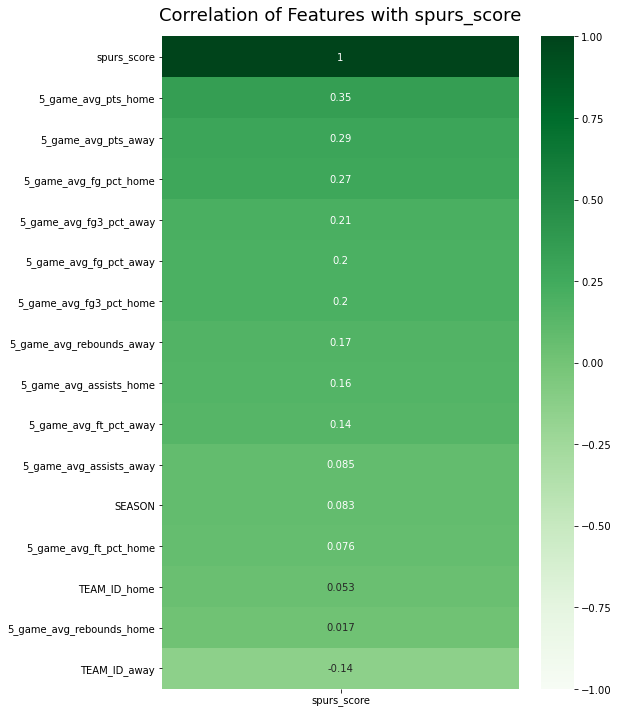

In [28]:
corr_heatmap(train)

In [29]:
# Remove columns that had a correlation less than .2:
cols = ['TEAM_ID_away','5_game_avg_rebounds_home','TEAM_ID_home',\
        '5_game_avg_ft_pct_home','SEASON','5_game_avg_assists_away','5_game_avg_ft_pct_away',\
        '5_game_avg_assists_home','5_game_avg_rebounds_away']
train.drop(columns=cols)
validate.drop(columns=cols)
test.drop(columns=cols)

,spurs_score,5_game_avg_pts_home,5_game_avg_pts_away,5_game_avg_fg_pct_home,5_game_avg_fg_pct_away,5_game_avg_fg3_pct_home,5_game_avg_fg3_pct_away
GAME_DATE_EST,,,,,,,
2018-09-30,104.0,103.6,98.8,0.4584,0.4038,0.3424,0.3018
2018-10-05,117.0,103.8,98.8,0.4586,0.4038,0.3616,0.3018
2018-10-07,93.0,102.8,98.8,0.4520,0.4038,0.3552,0.3018
2018-10-10,127.0,102.8,101.8,0.4520,0.4276,0.3552,0.3010
2018-10-12,100.0,102.8,102.2,0.4520,0.4292,0.3552,0.2984
...,...,...,...,...,...,...,...
2019-04-18,118.0,112.4,106.4,0.4964,0.4804,0.3818,0.3478
2019-04-20,103.0,109.8,106.4,0.4842,0.4804,0.3558,0.3478
2019-04-23,90.0,109.8,107.4,0.4842,0.4860,0.3558,0.3692


In [30]:
# drop target column
X_train = train.drop(columns = 'spurs_score')
y_train = train.spurs_score

X_validate = validate.drop(columns = 'spurs_score')
y_validate = validate.spurs_score

X_test = test.drop(columns = 'spurs_score')
y_test = test.spurs_score

(array([ 1.,  8., 27., 53., 63., 58., 43., 28., 10.,  5.]),
 array([ 74.,  80.,  86.,  92.,  98., 104., 110., 116., 122., 128., 134.]),
 <BarContainer object of 10 artists>)

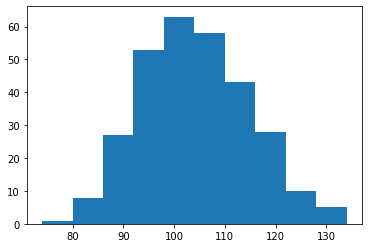

In [31]:
# Distribution of our target
plt.hist(y_train)

### Scaling my Data

In [32]:
scaler = MinMaxScaler()
# Note that we only call .fit with the training data,
# but we use .transform to apply the scaling to all the data splits.
scaler.fit(X_train)

X_train = scaler.transform(X_train)
X_validate = scaler.transform(X_validate)
X_test = scaler.transform(X_test)

### Create Baseline

In [33]:
# We need y_train, y_validate and y_test to be dataframes to append the new columns with predicted values. 
y_train = pd.DataFrame(y_train)
y_validate = pd.DataFrame(y_validate)
y_test = pd.DataFrame(y_test)

# 1. compute tax_value_pred_mean
spurs_score_pred_mean = y_train.spurs_score.mean()
y_train['spurs_score_pred_mean'] = spurs_score_pred_mean
y_validate['spurs_score_pred_mean'] = spurs_score_pred_mean

# 2. compute tax_value_pred_median
spurs_score_pred_median = y_train.spurs_score.median()
y_train['spurs_score_pred_median'] = spurs_score_pred_median
y_validate['spurs_score_pred_median'] = spurs_score_pred_median

# 3. RMSE of tax_value_pred_mean
rmse_train = mean_squared_error(y_train.spurs_score, y_train.spurs_score_pred_mean) ** .5
rmse_validate = mean_squared_error(y_validate.spurs_score, y_validate.spurs_score_pred_mean) ** .5

print("RMSE using Mean\nTrain/In-Sample: ", round(rmse_train, 2), 
      "\nValidate/Out-of-Sample: ", round(rmse_validate, 2))

RMSE using Mean
Train/In-Sample:  10.62 
Validate/Out-of-Sample:  11.16


In [34]:
# 4. RMSE of tax_value_pred_median
rmse_train = mean_squared_error(y_train.spurs_score, y_train.spurs_score_pred_median) ** .5
rmse_validate = mean_squared_error(y_validate.spurs_score, y_validate.spurs_score_pred_median) ** .5
print("RMSE using Median\nTrain/In-Sample: ", round(rmse_train, 2), 
      "\nValidate/Out-of-Sample: ", round(rmse_validate, 2))

RMSE using Median
Train/In-Sample:  10.64 
Validate/Out-of-Sample:  11.12


In [35]:
# create the metric_df as a blank dataframe
metric_df = pd.DataFrame()
# make our first entry into the metric_df with median baseline
metric_df = make_metric_df(y_train.spurs_score,
                           y_train.spurs_score_pred_mean,
                           'mean_baseline',
                          metric_df)
metric_df

,model,RMSE_validate,r^2_validate
0,mean_baseline,10.615598,0.0


### LinearRegression (OLS)

In [38]:
# create the model object
# 
# make the thing
# 
lm = LinearRegression(normalize=True)
# 
# fit the thing
# 
lm.fit(X_train, y_train.spurs_score)
# predict train
# 
# use the thing
# 
y_train['spurs_score_pred_lm'] = lm.predict(X_train)
# evaluate: rmse
rmse_train = mean_squared_error(y_train.spurs_score, y_train.spurs_score_pred_lm) ** .5

# predict validate
y_validate['spurs_score_pred_lm'] = lm.predict(X_validate)

# evaluate: rmse
rmse_validate = mean_squared_error(y_validate.spurs_score, y_validate.spurs_score_pred_lm) ** (1/2)

print("RMSE for OLS using LinearRegression\nTraining/In-Sample: ", rmse_train, 
      "\nValidation/Out-of-Sample: ", rmse_validate)

RMSE for OLS using LinearRegression
Training/In-Sample:  9.442026376759314 
Validation/Out-of-Sample:  11.82328914571667


In [39]:
metric_df = metric_df.append({
    'model': 'OLS Regressor', 
    'RMSE_validate': rmse_validate,
    'r^2_validate': explained_variance_score(y_validate.spurs_score, y_validate.spurs_score_pred_lm)}, ignore_index=True)
metric_df

,model,RMSE_validate,r^2_validate
0,mean_baseline,10.615598,0.000000
1,OLS Regressor,11.823289,-0.103772


### LassoLars

In [40]:
# create the model object
lars = LassoLars(alpha=1)

# fit the model to our training data. We must specify the column in y_train, 
# since we have converted it to a dataframe from a series!
lars.fit(X_train, y_train.spurs_score)

# predict train
y_train['spurs_score_pred_lars'] = lars.predict(X_train)

# evaluate: rmse
rmse_train = mean_squared_error(y_train.spurs_score, y_train.spurs_score_pred_lars) ** (1/2)

# predict validate
y_validate['spurs_score_pred_lars'] = lars.predict(X_validate)

# evaluate: rmse
rmse_validate = mean_squared_error(y_validate.spurs_score, y_validate.spurs_score_pred_lars) ** (1/2)

print("RMSE for Lasso + Lars\nTraining/In-Sample: ", rmse_train, 
      "\nValidation/Out-of-Sample: ", rmse_validate)

RMSE for Lasso + Lars
Training/In-Sample:  10.615597610059444 
Validation/Out-of-Sample:  11.163917076482761


In [41]:
metric_df = make_metric_df(y_validate.spurs_score,
               y_validate.spurs_score_pred_lars,
               'lasso_alpha_1',
               metric_df)

metric_df

,model,RMSE_validate,r^2_validate
0,mean_baseline,10.615598,0.000000e+00
1,OLS Regressor,11.823289,-1.037720e-01
2,lasso_alpha_1,11.163917,-2.220446e-16


### TweedieRegressor (GLM)

In [42]:
# create the model object
glm = TweedieRegressor(power=1, alpha=0)

# fit the model to our training data. We must specify the column in y_train, 
# since we have converted it to a dataframe from a series! 
glm.fit(X_train, y_train.spurs_score)

# predict train
y_train['spurs_score_pred_glm'] = glm.predict(X_train)

# evaluate: rmse
rmse_train = mean_squared_error(y_train.spurs_score, y_train.spurs_score_pred_glm) ** (1/2)

# predict validate
y_validate['spurs_score_pred_glm'] = glm.predict(X_validate)

# evaluate: rmse
rmse_validate = mean_squared_error(y_train.spurs_score, y_train.spurs_score_pred_glm) ** (1/2)

print("RMSE for GLM using Tweedie, power=1 & alpha=0\nTraining/In-Sample: ", rmse_train, 
      "\nValidation/Out-of-Sample: ", rmse_validate)

RMSE for GLM using Tweedie, power=1 & alpha=0
Training/In-Sample:  9.431479163920613 
Validation/Out-of-Sample:  9.431479163920613


In [43]:
metric_df = make_metric_df(y_validate.spurs_score,
               y_validate.spurs_score_pred_glm,
               'glm_poisson',
               metric_df)
metric_df

,model,RMSE_validate,r^2_validate
0,mean_baseline,10.615598,0.000000e+00
1,OLS Regressor,11.823289,-1.037720e-01
2,lasso_alpha_1,11.163917,-2.220446e-16
3,glm_poisson,11.780505,-9.350694e-02


### Polynomial Regression

In [44]:
# make the polynomial features to get a new set of features
pf = PolynomialFeatures(degree=1)

# fit and transform X_train_scaled
X_train_degree2 = pf.fit_transform(X_train)

# transform X_validate_scaled & X_test_scaled
X_validate_degree2 = pf.transform(X_validate)
X_test_degree2 =  pf.transform(X_test)

In [45]:
# create the model object
lm2 = LinearRegression(normalize=True)

# fit the model to our training data. We must specify the column in y_train, 
# since we have converted it to a dataframe from a series! 
lm2.fit(X_train_degree2, y_train.spurs_score)

# predict train
y_train['spurs_score_pred_lm2'] = lm2.predict(X_train_degree2)

# evaluate: rmse
rmse_train = mean_squared_error(y_train.spurs_score, y_train.spurs_score_pred_lm2) ** (1/2)

# predict validate
y_validate['spurs_score_pred_lm2'] = lm2.predict(X_validate_degree2) 

# evaluate: rmse
rmse_validate = mean_squared_error(y_validate.spurs_score, y_validate.spurs_score_pred_lm2) ** (1/2)

print("RMSE for Polynomial Model, degrees=2\nTraining/In-Sample: ", rmse_train, 
      "\nValidation/Out-of-Sample: ", rmse_validate)

RMSE for Polynomial Model, degrees=2
Training/In-Sample:  9.442026376759314 
Validation/Out-of-Sample:  11.823289145716668


In [46]:
metric_df = make_metric_df(y_validate.spurs_score,
               y_validate.spurs_score_pred_lm2,
               'quadratic',
               metric_df)
metric_df

,model,RMSE_validate,r^2_validate
0,mean_baseline,10.615598,0.000000e+00
1,OLS Regressor,11.823289,-1.037720e-01
2,lasso_alpha_1,11.163917,-2.220446e-16
3,glm_poisson,11.780505,-9.350694e-02
4,quadratic,11.823289,-1.037720e-01


### Plotting Actual vs Predicted Values

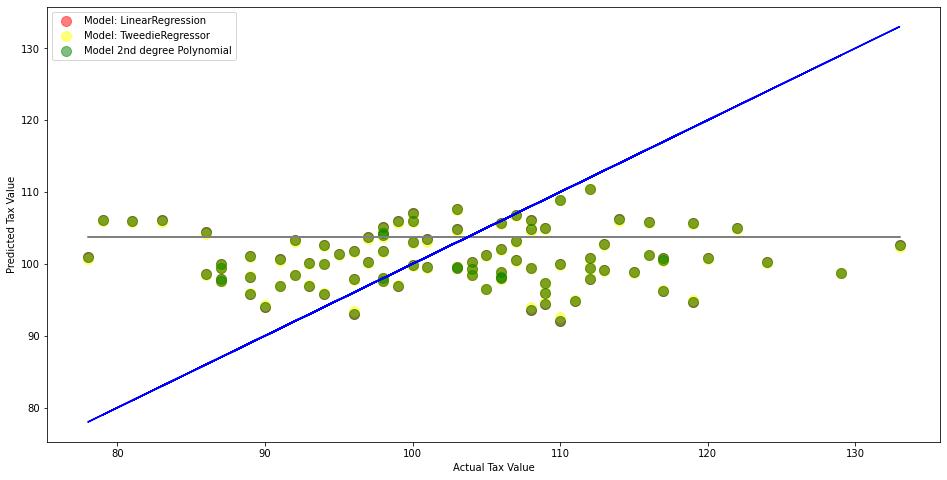

In [47]:
plt.figure(figsize=(16,8))
plt.plot(y_validate.spurs_score, y_validate.spurs_score_pred_mean, alpha=1, color="gray", label='_nolegend_')
plt.plot(y_validate.spurs_score, y_validate.spurs_score, alpha=1, color="blue", label='_nolegend_')

plt.scatter(y_validate.spurs_score, y_validate.spurs_score_pred_lm, 
            alpha=.5, color="red", s=100, label="Model: LinearRegression")
plt.scatter(y_validate.spurs_score, y_validate.spurs_score_pred_glm, 
            alpha=.5, color="yellow", s=100, label="Model: TweedieRegressor")
plt.scatter(y_validate.spurs_score, y_validate.spurs_score_pred_lm2, 
            alpha=.5, color="green", s=100, label="Model 2nd degree Polynomial")

plt.legend()
plt.xlabel("Actual Tax Value")
plt.ylabel("Predicted Tax Value")
plt.show()

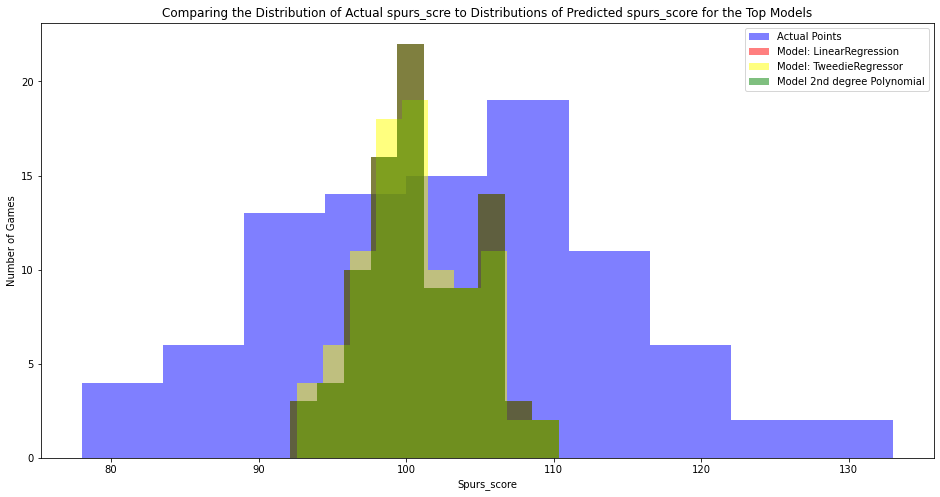

In [48]:
# plot to visualize actual vs predicted. 
plt.figure(figsize=(16,8))
plt.hist(y_validate.spurs_score, color='blue', alpha=.5, label="Actual Points")
plt.hist(y_validate.spurs_score_pred_lm, color='red', alpha=.5, label="Model: LinearRegression")
plt.hist(y_validate.spurs_score_pred_glm, color='yellow', alpha=.5, label="Model: TweedieRegressor")
plt.hist(y_validate.spurs_score_pred_lm2, color='green', alpha=.5, label="Model 2nd degree Polynomial")
plt.xlabel("Spurs_score")
plt.ylabel("Number of Games")
plt.title("Comparing the Distribution of Actual spurs_scre to Distributions of Predicted spurs_score for the Top Models")
plt.legend()
plt.show()

In [49]:
# create the model object
lars = LassoLars(alpha=1)

# fit the model to our training data. We must specify the column in y_train, 
# since we have converted it to a dataframe from a series!
lars.fit(X_train, y_train.spurs_score)

# predict train
y_train['spurs_score_pred_lars'] = lars.predict(X_train)
# evaluate: rmse
rmse_train = mean_squared_error(y_train.spurs_score, y_train.spurs_score_pred_lars) ** (1/2)

# predict validate
y_validate['spurs_score_pred_lars'] = lars.predict(X_validate)
# evaluate: rmse
rmse_validate = mean_squared_error(y_validate.spurs_score, y_validate.spurs_score_pred_lars) ** (1/2)

# predict test
y_test['spurs_score_pred_lars'] = lars.predict(X_test)
# evaluate: rmse
rmse_test = mean_squared_error(y_test.spurs_score, y_test.spurs_score_pred_lars) ** (1/2)



print("RMSE for Lasso + Lars\nTraining/In-Sample: ", rmse_train, 
      "\nValidation/Out-of-Sample: ", rmse_validate,
      "\nTest/Out-of-Sample: ", rmse_test)

RMSE for Lasso + Lars
Training/In-Sample:  10.615597610059444 
Validation/Out-of-Sample:  11.163917076482761 
Test/Out-of-Sample:  14.586886040827023


In [50]:
metric_df

,model,RMSE_validate,r^2_validate
0,mean_baseline,10.615598,0.000000e+00
1,OLS Regressor,11.823289,-1.037720e-01
2,lasso_alpha_1,11.163917,-2.220446e-16
3,glm_poisson,11.780505,-9.350694e-02
4,quadratic,11.823289,-1.037720e-01


### Takeaways

- While I'm definitely not taking this to Vegas any time soon, I did have fun learning and gaining some new techniques in this project
- I'm proud of the features I engineered from scratch (rolling season averages, total score for just spurs), even though I know with more time there are definitely better features I could try to incorporate (such as the W/L record, injuries, social media activity, etc.)
- I look forward to getting into webscrapping, incorporating more stats, and eventually growing this project into predicting every NBA game outcome, especially since the regular season is about to start!